# There are notes below each cell, discribing functionality

In [1]:
import numpy as np
import pandas as pd
from itertools import combinations
import fast_histogram as fh
import matplotlib.pyplot as plt
from scipy.stats import norm
import matplotlib as mpl

This simply imports things that will be needed for the program

In [2]:
data = pd.read_csv('/home/matteo/Documents/research/summer2019/coltrims/Acetonitrile/acetonitrile_28_54_2000_DAn.00000855_1725_9640_9765tripgroup.csv')
data['index0'] = data.index

Imports the data and adds the index as a column so that it can be saved when creating pairwise coincidences. This is so you can simply do the calculations to all the datapoints you will need, aka those that are gated with sumdif, and then populate a dataframe where each row is a coincidence.

If this is unclear, it should make more sense lower down.

In [3]:
#data.tof = data.tof.apply(lambda tof: tof/1000)
#data.x = data.x.apply(lambda x: x/1000)
#data.y = data.y.apply(lambda y: y/1000)

print(data.iloc[:10])


   delay       x       y       tof     id  index0
0    0.0  10.524 -17.099  4182.616  425.0       0
1    0.0  -6.605  12.551  5523.309  425.0       1
2    0.0 -13.270  -9.094  4166.588  481.0       2
3    0.0   2.501  -1.840  5586.698  481.0       3
4    0.0  15.996   3.885  4361.480  505.0       4
5    0.0 -10.678  -0.187  5308.952  505.0       5
6    0.0  -1.877   7.640  4161.252  717.0       6
7    0.0  16.993  -7.986  4187.372  717.0       7
8    0.0   2.013   0.800  5465.753  717.0       8
9    0.0   2.096  -2.795  4080.732  727.0       9


This changes the units of x, y, and tof such that x and y are in mm and tof is in ns

97.21891213557079 percent of data kept
3003134
[4182.616 5523.309 4166.588 ... 5414.734 4309.405 5332.93 ]


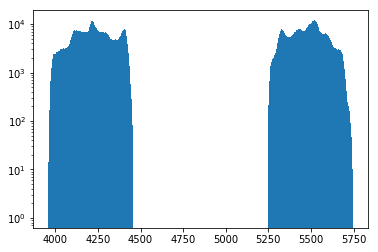

In [4]:
# if you are doing tripico, run this
value_counts = data['id'].value_counts()
coinc = data[data['id'].isin(value_counts[value_counts == 2].index)]
coinc.reset_index(inplace=True,drop=True)

print(str(coinc.shape[0]/data.shape[0]*100)+' percent of data kept') 
print(coinc.shape[0])

print(coinc['tof'].values)
plt.hist(coinc['tof'].values,bins=1000)
plt.yscale('log', nonposy='clip')
plt.rcParams["figure.figsize"] = [10,10]
plt.show()


In [5]:
#this is probably going to take forever no matter what, it is setting up every possible pairwise combination

#data = data.iloc[:2000000]
'''
pairwise = pd.DataFrame([[k, c0, c1,c2] for k, index in data.groupby('id').index0
                                  for c0, c1 , c2 in combinations(index, 3)
                             ], columns=['id', 'index1', 'index2','index3'])
'''




pairwise = pd.DataFrame([[k, c0, c1] for k, index in coinc.groupby('id').index0
                                  for c0, c1 in combinations(index, 2)
                             ], columns=['id', 'index1', 'index2'])




In [6]:
print(pairwise.iloc[:10])

       id  index1  index2
0   425.0       0       1
1   481.0       2       3
2   505.0       4       5
3   727.0       9      10
4  1551.0      11      12
5  1559.0      13      14
6  2934.0      15      16
7  3812.0      17      18
8  4152.0      19      20
9  4389.0      21      22


3133.0


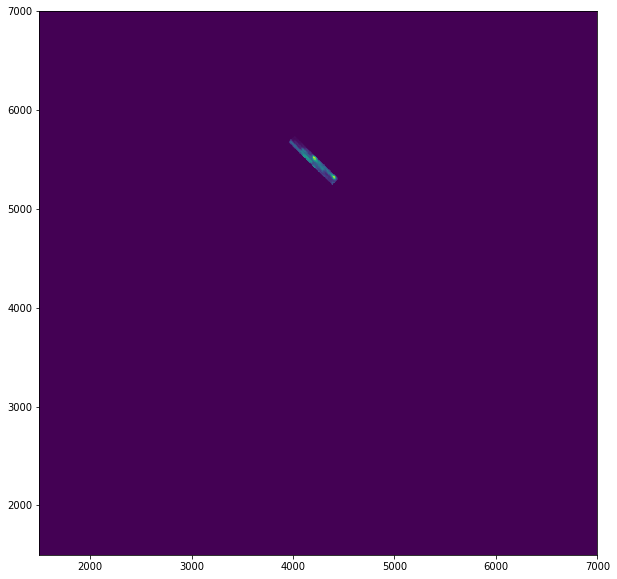

In [7]:
def pipico(tmin,tmax,binN,dataIndexes):
    
    y = data.loc[dataIndexes['index2']]['tof'].reset_index(drop=True)
    x = data.loc[dataIndexes['index1']]['tof'].reset_index(drop=True)#+data.loc[dataIndexes['index2']]['tof'].reset_index(drop=True)
    
    
    hist = fh.histogram2d(y,x,range = [[tmin,tmax],[tmin,tmax]],bins = binN)

    #hist = np.log(hist)
    #hist[hist == -np.inf] = 0

    
    print(hist.max())

    dx = (tmax-tmin)/binN

    y, x = np.mgrid[slice(tmin, tmax + dx, dx),
    slice(tmin, tmax + dx, dx)]

    plt.pcolormesh(x,y,hist)
    plt.rcParams["figure.figsize"] = [10,10]
    plt.show()


pipico(1500,7000,1000,pairwise)


Creates all pairwise combinations of detections in the same event so that sumdif gating can be applied

False    878435
True     623132
Name: yes, dtype: int64


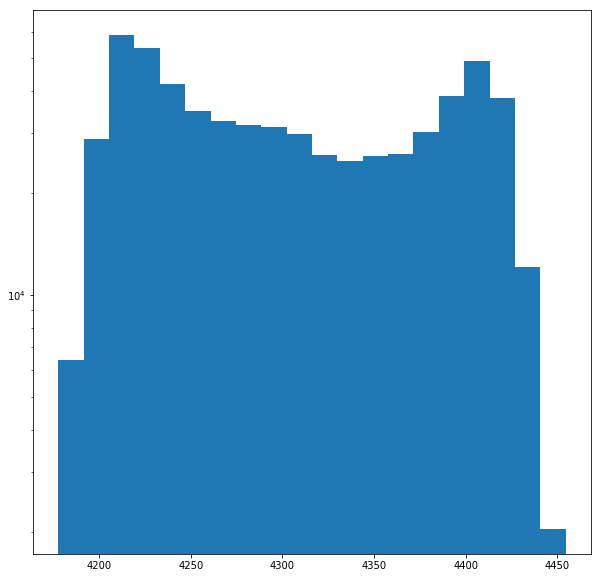

In [36]:
temp = pd.DataFrame()
temp['INDEX1'] = data.iloc[pairwise['index1'].values].tof.values
temp['INDEX2'] = data.iloc[pairwise['index2'].values].tof.values
#temp['INDEX3'] = data.iloc[pairwise['index3'].values].tof.values




temp['check1'] = ((temp['INDEX1']+temp['INDEX2'])<9765)
temp['check2'] = ((temp['INDEX2']+temp['INDEX1'])>9700) 
temp['check3'] = ((temp['INDEX2']-temp['INDEX1'])<1345) 
temp['check4'] = ((temp['INDEX1'])>0) 


temp['yes'] = (temp['check1']) & (temp['check2']) & (temp['check3']) 
print(temp['yes'].value_counts())

cutIndexes = pairwise[temp['yes']].reset_index(drop=True)

#print(list(cutIndexes['index1']))

plt.hist(data.iloc[cutIndexes.index1.values].tof,bins=20)
plt.yscale('log')
plt.show()




#print(temp)
#print(indList)

This function actually goes through the process of doing the gating

In [37]:
indList = [int(col[-1]) for col in cutIndexes if col.startswith('index')]

print(cutIndexes.shape[0],'rows')
print(cutIndexes)

623132 rows
                 id   index1   index2
0             425.0        0        1
1            4152.0       19       20
2            5570.0       25       26
3            9925.0       41       42
4           14229.0       53       54
5           14412.0       55       56
6           16153.0       61       62
7           16508.0       63       64
8           16735.0       65       66
9           16841.0       67       68
10          17523.0       71       72
11          18112.0       77       78
12          18129.0       79       80
13          20331.0       85       86
14          21594.0       91       92
15          23160.0       97       98
16          24411.0      103      104
17          26480.0      109      110
18          27182.0      113      114
19          27712.0      118      119
20          28503.0      122      123
21          30573.0      126      127
22          31602.0      130      131
23          32532.0      132      133
24          33380.0      134      135


Completes the gating with the above gates.

Format: [difmin, difmax, summin, summax]

Also creates a list of the indexes numerically

/usr/lib/python3.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: divide by zero encountered in log
  


7.8551570058813445


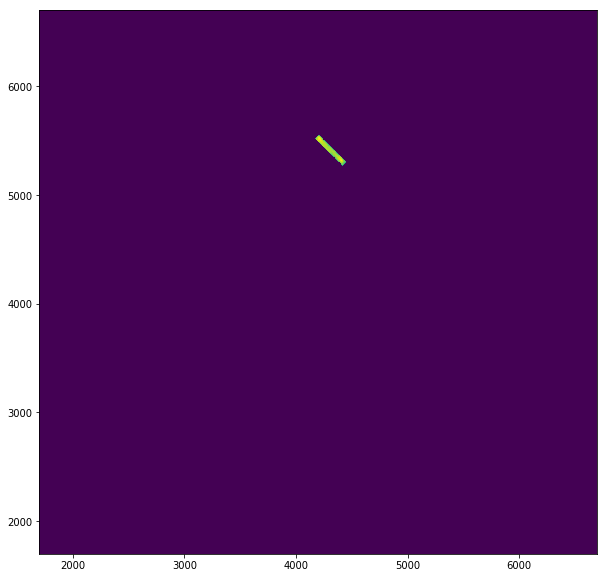

In [38]:
def tripico(tmin,tmax,binN,dataIndexes):
    
    y = data.loc[dataIndexes['index2']]['tof'].reset_index(drop=True)
    x = data.loc[dataIndexes['index1']]['tof'].reset_index(drop=True)#+data.loc[dataIndexes['index2']]['tof'].reset_index(drop=True)
    
    hist = fh.histogram2d(y,x,range = [[tmin,tmax],[tmin,tmax]],bins = binN)

    hist = np.log(hist)
    hist[hist == -np.inf] = 0

    print(hist.max())

    dx = (tmax-tmin)/binN

    y, x = np.mgrid[slice(tmin, tmax + dx, dx),
    slice(tmin, tmax + dx, dx)]

    plt.pcolormesh(x,y,hist)
    plt.rcParams["figure.figsize"] = [10,10]
    plt.show()


tripico(1700,6700,1000,cutIndexes)


In [39]:
#compList = pd.DataFrame(np.unique(np.concatenate((cutIndexes['index1'].values,cutIndexes['index2'].values,cutIndexes['index3'].values),axis=0)),columns=['index0'])
compList = pd.DataFrame(np.sort(np.append(cutIndexes['index1'].values,cutIndexes['index2'].values)),columns=['index0']).drop_duplicates().reset_index(drop=True)

Generates a dataframe with a complete list of the indexes of the datafile that were left over after the gating. The momentum and other physics calculations that just involve one particle will be done here, since you can populate the coincidence dataframe later with that info. 

(Man I love Pandas, those one-liners are so nice)

In [40]:
def dataPopulation(data,compList):
        
    temp = data.loc[compList['index0']][['x','y','tof','id','delay']]
    return temp


compList = dataPopulation(data,compList)
#compList['id'] = data.iloc[compList['index0'].values].id.reset_index(drop=True)

print(compList.iloc[:8])

         x       y       tof      id  delay
0   10.524 -17.099  4182.616   425.0    0.0
1   -6.605  12.551  5523.309   425.0    0.0
19  -5.765  -5.862  4203.557  4152.0    0.0
20   4.730   1.114  5545.380  4152.0    0.0
25   2.257 -11.795  4383.476  5570.0    0.0
26  -0.635   8.386  5351.851  5570.0    0.0
41  13.559   2.439  4231.765  9925.0    0.0
42  -8.151  -2.163  5507.208  9925.0    0.0


Fills in the data in the Dataframe of the post-cut detections

0.16005787936521843 -0.2217256484421447


<Figure size 720x720 with 0 Axes>

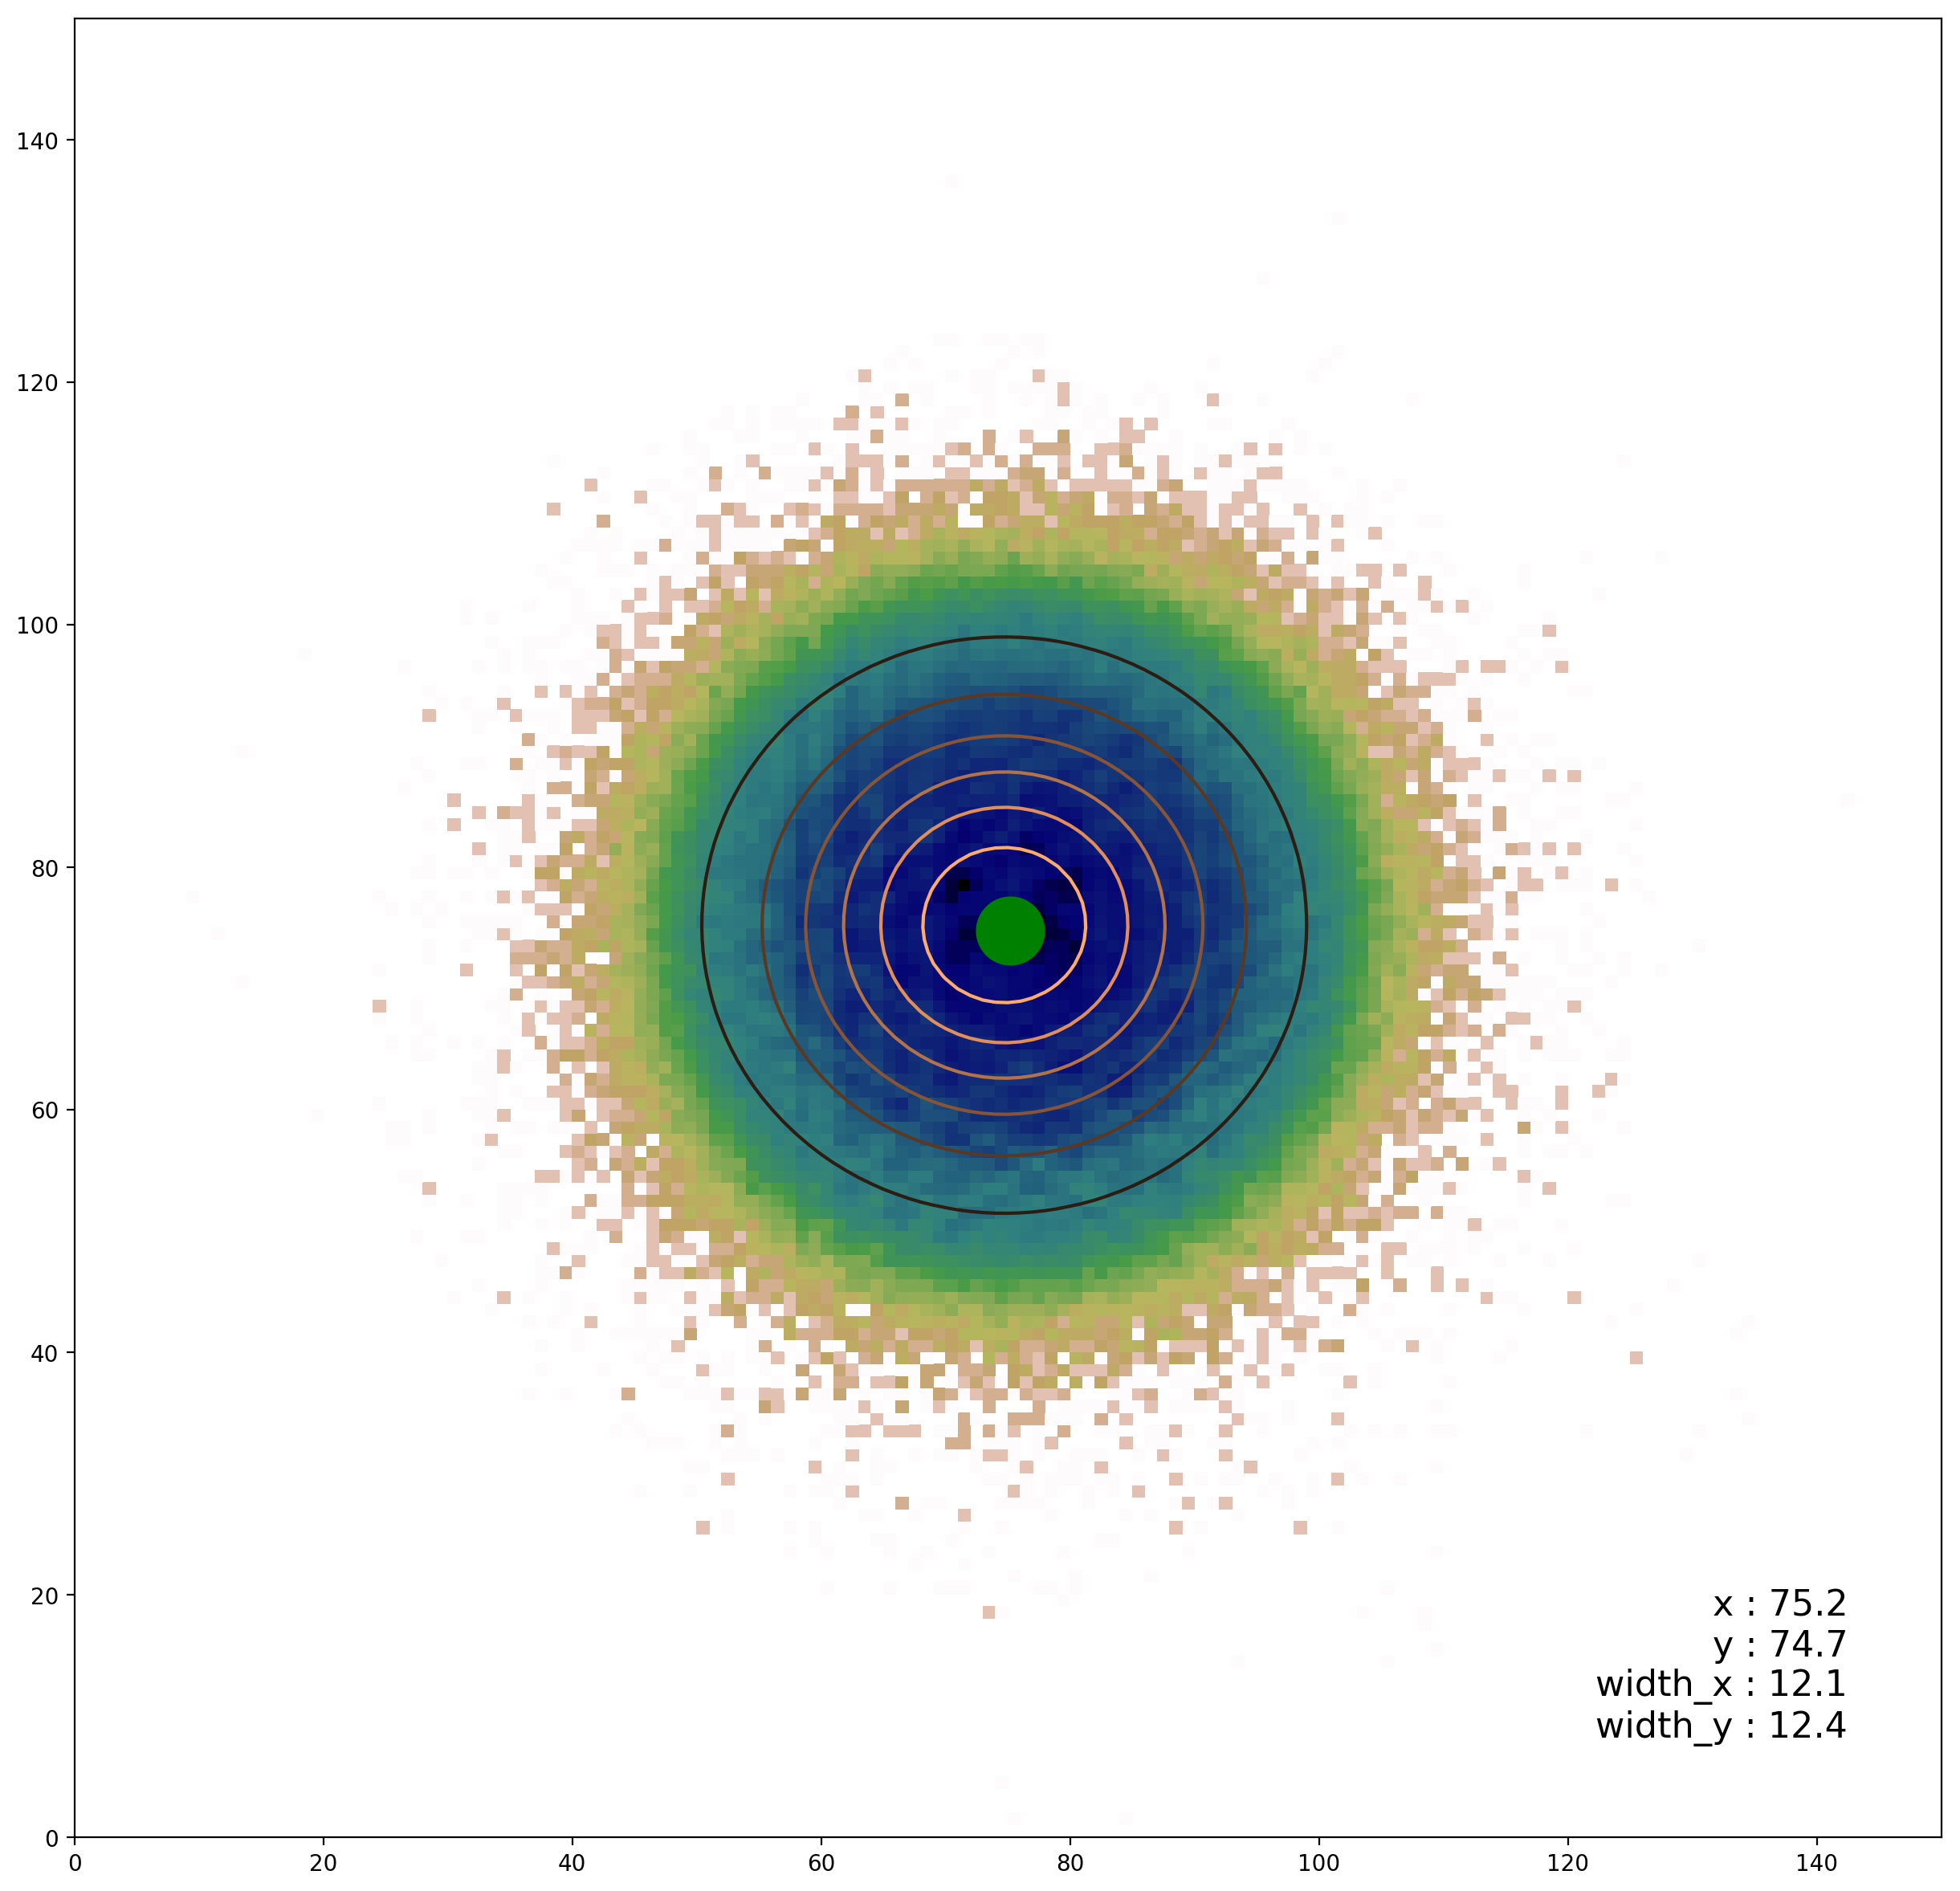

In [41]:
def getCenter(datalist):
    
    from helper import center_by_moments
    
    xmin = -60
    xmax = 60
    xbin = 150

    xy_hist = fh.histogram2d(datalist['x'],datalist['y'],range = [[xmin,xmax],[xmin,xmax]],bins = xbin)

    dx = (xmax- xmin)/xbin

    y_, x_ = np.mgrid[slice(xmin, xmax, dx),
               slice(xmin, xmax, dx)]

    x0,y0 = center_by_moments(x_[0],x_[0],xy_hist,True)
    
    return float(x0),float(y0)

x0, y0 = getCenter(compList)
print(x0,y0)

Gets the center of physics of the cut data.

In [42]:
from helper import fitEfield
from helper import GetZVelocity

E_field_new, ion_drift_length_new, t0_new = fitEfield()

print(t0_new)

ion_accel_length = 0.27

#in increasing order of mass (ie, mass of t1, mass of t2, etc)
#and the corisponding charge
mass = [14,26]
mass_si = [(m * 1.66056e-27) for m in mass]
charge = [1,1]

t0_new = 1248 #modify till pz is centered 


def apInd(string,ind):
    
    return string+str(ind)


<Parameter 't0', value=1270.3948332250093 +/- 2.44, bounds=[-inf:inf]>


The above cell sets up calculating the three componants of momenta. It and the two cells below are (I think) generalized for tripico as well.

Change mass and charge as needed. 

In [43]:
def filldata(compList,cutIndexes):
    
    addit = [cutIndexes]
    
    for ind in indList:
        
        temp0 = data.loc[cutIndexes[apInd('index',ind)]][['x','y','tof','delay']].reset_index(drop=True)
        temp0.columns = [apInd(col,ind) for col in temp0]
        addit.append(temp0)
  
    return pd.concat(addit, axis=1)
    

coincXYT = filldata(compList,cutIndexes)

  
print(coincXYT)


                 id   index1   index2      x1      y1      tof1  delay1  \
0             425.0        0        1  10.524 -17.099  4182.616   0.000   
1            4152.0       19       20  -5.765  -5.862  4203.557   0.000   
2            5570.0       25       26   2.257 -11.795  4383.476   0.000   
3            9925.0       41       42  13.559   2.439  4231.765   0.000   
4           14229.0       53       54  12.326  16.802  4334.700   5.173   
5           14412.0       55       56  -1.119  -7.828  4215.299   5.173   
6           16153.0       61       62 -15.764  15.553  4290.179   5.173   
7           16508.0       63       64   2.729  -7.923  4237.890   5.173   
8           16735.0       65       66  12.994 -10.752  4224.466   5.173   
9           16841.0       67       68  -3.284  -7.604  4424.345   5.173   
10          17523.0       71       72  -5.840  10.887  4389.614   5.173   
11          18112.0       77       78  -9.826 -22.078  4210.700   5.173   
12          18129.0      

In [44]:
def velocP(coincXYT):
    
    addit = [coincXYT]
    
    for ind in indList:      
        
        temp = pd.DataFrame()
        
        temp[apInd('tof0',ind)] = coincXYT[apInd('tof',ind)]-t0_new   
     
        temp[apInd('vx',ind)] = (coincXYT[apInd('x',ind)] - (x0+.31)) / (coincXYT[apInd('tof',ind)] - t0_new) * 1000000
        temp[apInd('vy',ind)] = (coincXYT[apInd('y',ind)] - (y0+.385)) / (coincXYT[apInd('tof',ind)] - t0_new) * 1000000
        temp[apInd('vz',ind)] = temp[apInd('tof0',ind)].apply(GetZVelocity,args=(mass[ind-1],charge[ind-1],E_field_new, ion_accel_length ,ion_drift_length_new))    
        
        temp[apInd('px',ind)] = mass_si[ind-1] * temp[apInd('vx',ind)] * 0.5 * 1e24
        temp[apInd('py',ind)] = mass_si[ind-1] * temp[apInd('vy',ind)] * 0.5 * 1e24
        temp[apInd('pz',ind)] = mass_si[ind-1] * temp[apInd('vz',ind)] * 0.5 * 1e24
    
        addit.append(temp)

    return(pd.concat(addit, axis=1))
    

completePop = velocP(coincXYT.iloc[:10000])

print(completePop.shape)
#print(completePop)

(10000, 25)


Populates all three components of velocity, as well as the momentum for every detection selected with the cut, using the masses and charges given above.

In [45]:
'''
completePop['pxsum'] = completePop[['px1','px2','px3']].sum(axis=1)
completePop['pysum'] = completePop[['py1','py2','py3']].sum(axis=1)
completePop['pzsum'] = completePop[['pz1','pz2','pz3']].sum(axis=1)
'''
completePop['pxsum'] = completePop[['px1','px2']].sum(axis=1)
completePop['pysum'] = completePop[['py1','py2']].sum(axis=1)
completePop['pzsum'] = completePop[['pz1','pz2']].sum(axis=1)

(0.625837318988394, 11.65327422128507)


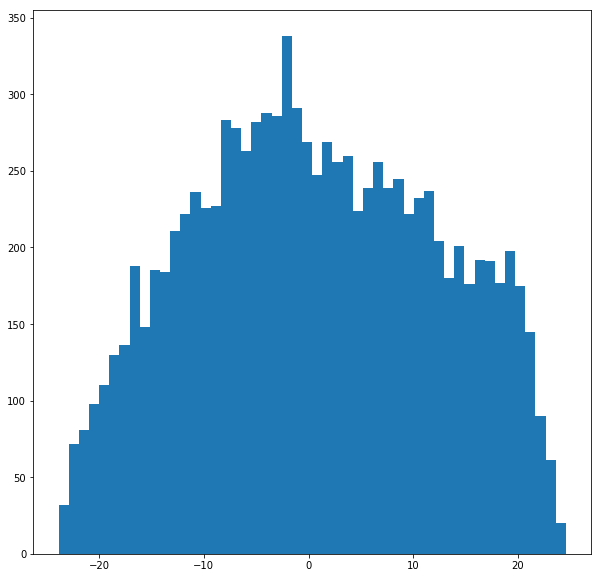

In [48]:
pCur = completePop['pzsum']
plt.hist(pCur,bins=50)
print(norm.fit(pCur))
plt.show()

In [49]:
plist = [col for col in completePop if col.startswith('p')]
plist_si = [p+'_si' for p in plist]
print(plist,plist_si)

for p_si in plist_si:
    
    completePop[p_si] = completePop[p_si[:-3]] * 2e-24 


['px1', 'py1', 'pz1', 'px2', 'py2', 'pz2', 'pxsum', 'pysum', 'pzsum'] ['px1_si', 'py1_si', 'pz1_si', 'px2_si', 'py2_si', 'pz2_si', 'pxsum_si', 'pysum_si', 'pzsum_si']


In [50]:
completePop['KE1_ev'] = (completePop['px1_si']**2 + completePop['py1_si']**2 + completePop['pz1_si']**2) /(2*mass_si[0]) *6.242e18
completePop['KE2_ev'] = (completePop['px2_si']**2 + completePop['py2_si']**2 + completePop['pz2_si']**2) /(2*mass_si[1]) *6.242e18
#completePop['KE3_ev'] = (completePop['px3_si']**2 + completePop['py3_si']**2 + completePop['pz3_si']**2) /(2*mass_si[2]) *6.242e18

(10000, 39)


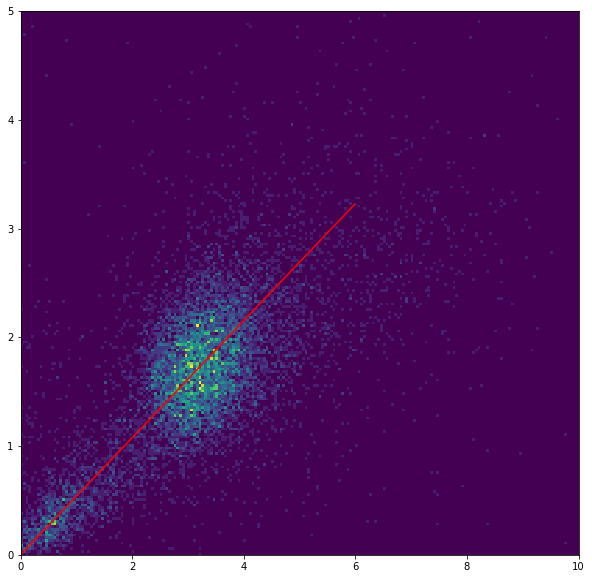

In [51]:
print(completePop.shape)
xx_ = np.arange(0,6,.01)
yy_ = xx_*(mass[0]/mass[1])

plt.hist2d(completePop.KE1_ev,completePop.KE2_ev,bins=200,range=[[0,10],[0,5]])
plt.plot(xx_,yy_,'r')
plt.show()

In [52]:
completePop['KER_ev'] = completePop['KE1_ev'] + completePop['KE2_ev'] 

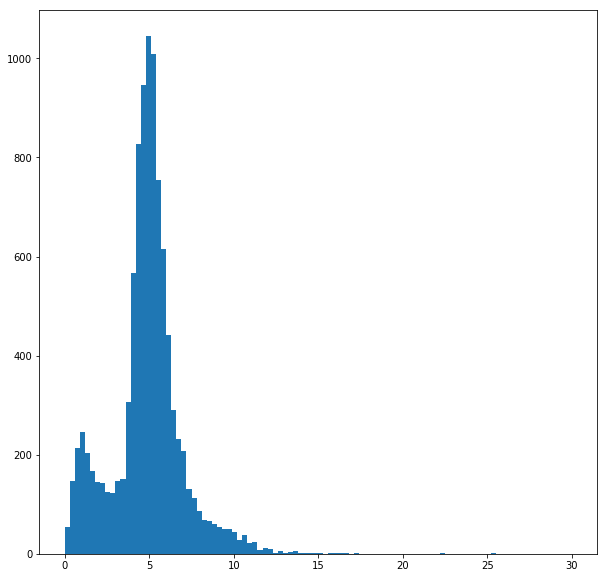

In [53]:
plt.hist(completePop.KER_ev,bins=100,range=[0,30])
plt.show()

In [54]:
completePop['ptot'] = (completePop['pxsum']**2 + completePop['pysum']**2 + completePop['pzsum']**2)**.5

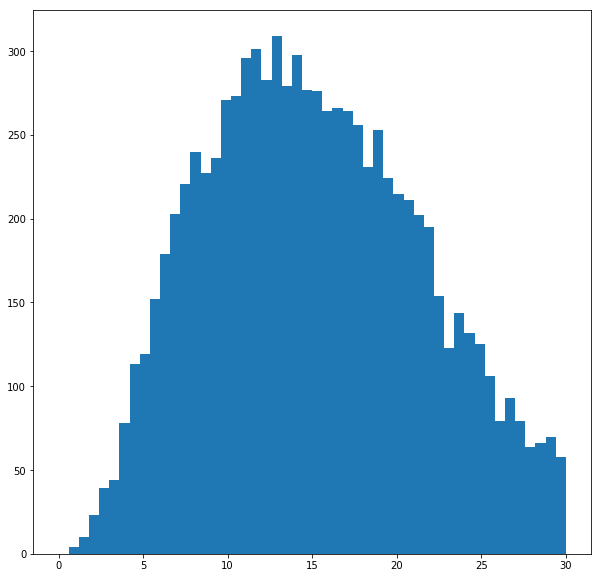

In [55]:
plt.hist(completePop.ptot,bins=50,range=[0,30])
plt.show()

(10000, 41)


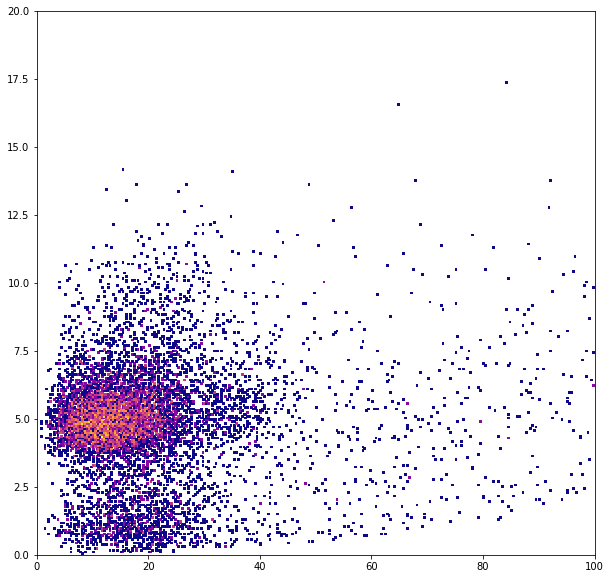

In [58]:
print(completePop.shape)
plt.hist2d(completePop.ptot,completePop.KER_ev,bins=300,norm=mpl.colors.LogNorm(),cmap=mpl.cm.plasma,range=[[0,100],[0,20]])
plt.show()

In [59]:
keCut = completePop[completePop['ptot'] < 35 ]
print(keCut.shape[0]/completePop.shape[0])

0.899


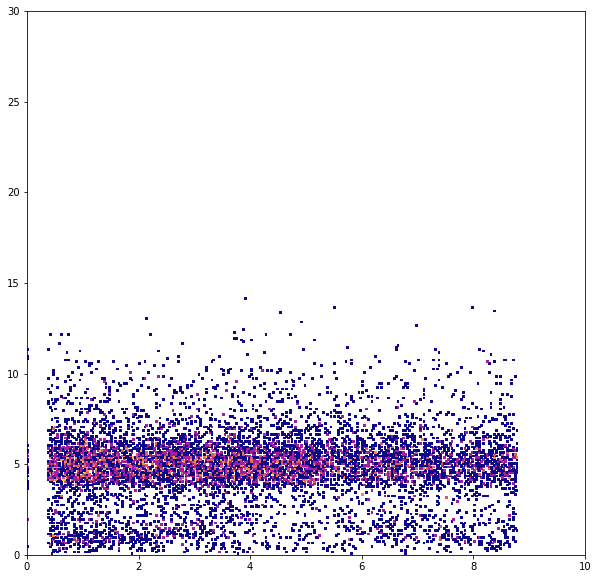

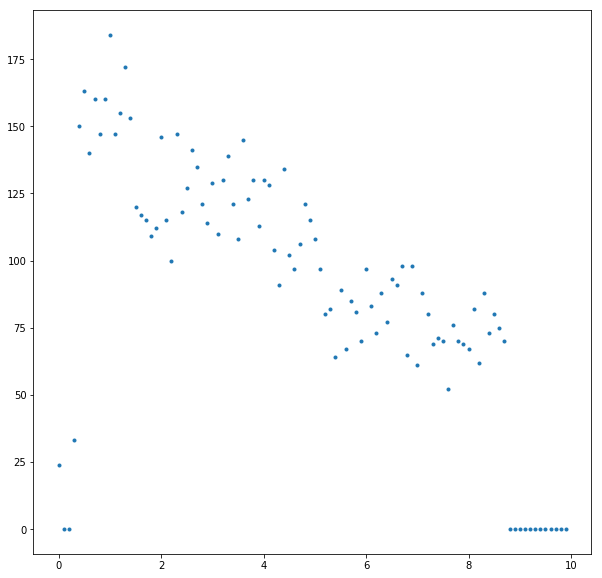

In [60]:
plt.hist2d(keCut.delay1,keCut.KER_ev,bins=300,range= [[0, 10], [0, 30]],norm=mpl.colors.LogNorm(),cmap=mpl.cm.plasma)
plt.show()

hist_ = fh.histogram2d(keCut.KER_ev,keCut.delay1,range= [[0,30],[0,10]],bins = 100)



plt.plot(np.arange(0,10,.1),list(hist_.sum(axis=0)),'.')
plt.show()

In [29]:
kECut = completePop[completePop['KER_ev'] < 7]


In [30]:
pX = pd.concat([kECut['px1'],kECut['px2'],keCut['pz1']])
pY = pd.concat([kECut['py1'],kECut['py2'],keCut['pz1']])
pZ = pd.concat([kECut['pz1'],kECut['pz2'],keCut['pz3']])


#plt.hist2d(kECut.pz1,kECut.px1+kECut.py1,bins=300,range=[[-100,100],[-140,120]])
plt.hist2d(pX,(pY+pZ)/np.sqrt(2),bins=300,range=[[-130,130],[-130,130]],cmap=mpl.cm.plasma)
plt.show()

KeyError: 'pz3'

In [ ]:
from helper import cosineAnglefromMomenta

kECut['cos1'] = cosineAnglefromMomenta(kECut['px1'],kECut['py1'],kECut['pz1'],kECut['px3'],kECut['py3'],kECut['pz3'])
kECut['cos2'] = cosineAnglefromMomenta(kECut['px2'],kECut['py2'],kECut['pz2'],kECut['px3'],kECut['py3'],kECut['pz3'])




In [ ]:
kECut['p1tot'] = (kECut['px1']**2+kECut['py1']**2+kECut['pz1']**2)**.5
kECut['p2tot'] = (kECut['px2']**2+kECut['py2']**2+kECut['pz2']**2)**.5
#kECut['p3tot'] = (kECut['px3']**2+kECut['py3']**2+kECut['pz3']**2)**.5

kECut['newt_x1'] = kECut['cos1']*kECut['p1tot']
kECut['newt_y1'] = (kECut['p1tot']**2-kECut['newt_x1']**2)**.5

kECut['newt_x2'] = kECut['cos2']*kECut['p2tot']
kECut['newt_y2'] = -1*(kECut['p2tot']**2-kECut['newt_x2']**2)**.5



print(kECut)



In [ ]:
import matplotlib.animation as animation
from IPython.display import HTML

tmin = -50
tmax = 50
binN = 250

'''
hist1 = fh.histogram2d(kECut['newt_y1'],kECut['newt_x1'],range= [[tmin,tmax],[tmin,tmax]],bins = binN)
hist2 = fh.histogram2d(kECut['newt_y2'],kECut['newt_x2'],range= [[tmin,tmax],[tmin,tmax]],bins = binN)


hist = hist1+hist2

dx = (tmax-tmin)/binN

y, x = np.mgrid[slice(tmin, tmax + dx, dx),
slice(tmin, tmax + dx, dx)]

plt.pcolormesh(x,y,hist,norm=mpl.colors.LogNorm() )
plt.rcParams["figure.figsize"] = [15,15]
plt.show()
'''

step_n = 3
max_delay = 1300

step_size = (8.776-4.6)/step_n
delay_step= max_delay/step_n

def newt_getslice(n):

    cent = 4.6
    maxi = 8.778 

    lowp = cent+ step_size*n
    higp = cent+ step_size*(n+1)
    
    lowm = cent- step_size*n
    higm = cent- step_size*(n+1)
    
    
    
    
    x1 = pd.concat([kECut['newt_x1'][(kECut['delay1']> lowp)&(kECut['delay1']<higp)],
                    kECut['newt_x1'][(kECut['delay1']> higm)&(kECut['delay1']<lowm)]])
    
    y1 = pd.concat([kECut['newt_y1'][(kECut['delay1']> lowp)&(kECut['delay1']<higp)],
                    kECut['newt_y1'][(kECut['delay1']> higm)&(kECut['delay1']<lowm)]])
    
    
    x2 = pd.concat([kECut['newt_x2'][(kECut['delay1']> lowp)&(kECut['delay1']<higp)],
                    kECut['newt_x2'][(kECut['delay1']> higm)&(kECut['delay1']<lowm)]])
    
    y2 = pd.concat([kECut['newt_y2'][(kECut['delay1']> lowp)&(kECut['delay1']<higp)],
                    kECut['newt_y2'][(kECut['delay1']> higm)&(kECut['delay1']<lowm)]])
    
    
    hist1 = fh.histogram2d(y1,x1,range= [[tmin,tmax],[tmin,tmax]],bins = binN)
    hist2 = fh.histogram2d(y2,x2,range= [[tmin,tmax],[tmin,tmax]],bins = binN)
    
    hist = hist1+hist2

    print(hist.sum())
    dx = (tmax-tmin)/binN

    y, x = np.mgrid[slice(tmin, tmax + dx, dx),
    slice(tmin, tmax + dx, dx)]

    plt.pcolormesh(x,y,hist,norm=mpl.colors.LogNorm())
    plt.rcParams["figure.figsize"] = [15,15]

    plt.title(str(int(delay_step*n))+' to '+str(int(delay_step*(n+1)))+' fs')
    plt.ylabel('Momentum (AU)')
    plt.xlabel('Momentum (AU)')
    #plt.show()
    plt.savefig('tmp'+str(n)+'.png')
    plt.close()

for i in range(step_n):   
    newt_getslice(i)
